<div style="text-align: center; line-height: 0; padding-top: 2px;">
  <img src="https://www.quantiaconsulting.com/logos/quantia_logo_orizz.png" alt="Quantia Consulting" style="width: 600px; height: 250px">
</div>

# Final Challenge - Solution
---

## Using the KDDCup dataset, find the best SML model

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

The KDDCup intrusion detection data stream records intrusions simulated in a military network environment. The task is to classify network traffic into **normal** (80.31% of the cases) or some kind of **intrusion** (19.69% of the cases) described by *41 features*, of which *34 numeric* and *7 nominal*. The problem of temporal dependence is particularly evident here. Inspecting the raw stream confirms that there are time periods of intrusions rather than single instances of intrusions.
The *7 nominal* attributes are:
- protocol_type
- service
- flag
- land
- logged_in
- is_host_login
- is_guest_login

**Class:** `class` | 0: normal, 1: intrusion
 
**Samples:** 494021


In [14]:
df = pd.read_csv("../datasets/KDDCup.csv")#.iloc[:10000,:]
features = df.columns[:-1]
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

## Plot data distribution
---
Encode the protocol_type, service and flag attributes and apply the **PCA**

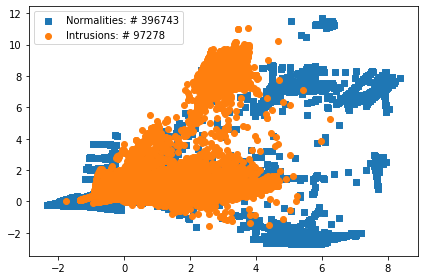

In [13]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

encoder = OrdinalEncoder()
encDf = df.copy()
encDf[["protocol_type","service","flag"]] = encoder.fit_transform(encDf[["protocol_type","service","flag"]])


features = encDf.drop(["class"],axis=1)
label = encDf["class"]

scaled_features = StandardScaler().fit_transform(features)
num_components = 2
pca = PCA(n_components=num_components)
pca_data = pca.fit_transform(scaled_features)
pca_data.shape

pc_df = pd.DataFrame(data = pca_data,columns = ["pc1", "pc2"])
pc_df["class"] = label

normalities = pc_df[pc_df["class"] == 0]
intrusions = pc_df[pc_df["class"] == 1]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x=normalities["pc1"], y=normalities["pc2"], marker="s", label='Normalities: # ' + str(normalities.shape[0]))
ax1.scatter(x=intrusions["pc1"], y=intrusions["pc2"], marker="o", label='Intrusions: # ' + str(intrusions.shape[0]))
plt.legend(loc='upper left');
fig.tight_layout()
plt.show()

## Find the best SML model!
---
### Hint
Since the stream is imbalances, the Accuracy is not a reliable metric. Try using [BalancedAccuracy](https://riverml.xyz/latest/api/metrics/BalancedAccuracy/) and [GeometricMean](https://riverml.xyz/latest/api/metrics/GeometricMean/) instead. To combine them, use [Metrics](https://riverml.xyz/latest/api/metrics/Metrics/)

In [36]:
from river.stream import iter_pandas
from river.evaluate import progressive_val_score
from river.metrics import BalancedAccuracy
from river.metrics import GeometricMean
from river import compose
from river.metrics import Metrics

## Naïve Bayes

In [39]:
from river.naive_bayes import GaussianNB

model = (
    compose.Discard('protocol_type','service', 'flag') |
    GaussianNB()
)
metric = Metrics(metrics=[BalancedAccuracy(),GeometricMean()])
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metric,
                      print_every=50000)

[50,000] BalancedAccuracy: 79.69%, GeometricMean: 0.784116
[100,000] BalancedAccuracy: 88.58%, GeometricMean: 0.885725
[150,000] BalancedAccuracy: 87.94%, GeometricMean: 0.877084
[200,000] BalancedAccuracy: 89.05%, GeometricMean: 0.887413
[250,000] BalancedAccuracy: 89.54%, GeometricMean: 0.891926
[300,000] BalancedAccuracy: 89.82%, GeometricMean: 0.894456
[350,000] BalancedAccuracy: 87.85%, GeometricMean: 0.872211
[400,000] BalancedAccuracy: 87.82%, GeometricMean: 0.871664
[450,000] BalancedAccuracy: 87.82%, GeometricMean: 0.871344


BalancedAccuracy: 84.92%, GeometricMean: 0.837914

## Hoeffding Adaptive Tree

In [40]:
from river.tree import HoeffdingAdaptiveTreeClassifier

model = HoeffdingAdaptiveTreeClassifier(nominal_attributes=['protocol_type','service', 'flag'], seed=42)
metric = Metrics(metrics=[BalancedAccuracy(),GeometricMean()])
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream, 
                      model=model, 
                      metric=metric, 
                      print_every=50000)

[50,000] BalancedAccuracy: 99.34%, GeometricMean: 0.993363
[100,000] BalancedAccuracy: 98.57%, GeometricMean: 0.985713
[150,000] BalancedAccuracy: 98.51%, GeometricMean: 0.985123
[200,000] BalancedAccuracy: 98.80%, GeometricMean: 0.987992
[250,000] BalancedAccuracy: 98.93%, GeometricMean: 0.989254
[300,000] BalancedAccuracy: 99.00%, GeometricMean: 0.989963
[350,000] BalancedAccuracy: 98.71%, GeometricMean: 0.987052
[400,000] BalancedAccuracy: 98.51%, GeometricMean: 0.985032
[450,000] BalancedAccuracy: 98.55%, GeometricMean: 0.985486


BalancedAccuracy: 98.67%, GeometricMean: 0.986714

## Adaptive Random Forest

In [42]:
from river.ensemble import AdaptiveRandomForestClassifier

model = AdaptiveRandomForestClassifier(n_models=5,nominal_attributes=['protocol_type','service', 'flag'])
metric = Metrics(metrics=[BalancedAccuracy(),GeometricMean()])
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metric,
                      print_every=50000)

[50,000] BalancedAccuracy: 99.65%, GeometricMean: 0.996469
[100,000] BalancedAccuracy: 99.70%, GeometricMean: 0.997023
[150,000] BalancedAccuracy: 99.69%, GeometricMean: 0.996925
[200,000] BalancedAccuracy: 99.79%, GeometricMean: 0.997855
[250,000] BalancedAccuracy: 99.83%, GeometricMean: 0.998265
[300,000] BalancedAccuracy: 99.85%, GeometricMean: 0.998495
[350,000] BalancedAccuracy: 99.84%, GeometricMean: 0.998377
[400,000] BalancedAccuracy: 99.84%, GeometricMean: 0.998369
[450,000] BalancedAccuracy: 99.84%, GeometricMean: 0.998433


BalancedAccuracy: 99.84%, GeometricMean: 0.99843

## ADWIN Online Bagging

In [43]:
from river.ensemble import ADWINBaggingClassifier
from river.tree import HoeffdingTreeClassifier

model = ADWINBaggingClassifier(model=HoeffdingTreeClassifier(nominal_attributes=['protocol_type','service', 'flag']),
                          n_models=5,
                          seed=42)
metric = Metrics(metrics=[BalancedAccuracy(),GeometricMean()])
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metric,
                      print_every=50000)


[50,000] BalancedAccuracy: 97.85%, GeometricMean: 0.978347
[100,000] BalancedAccuracy: 98.86%, GeometricMean: 0.98862
[150,000] BalancedAccuracy: 98.90%, GeometricMean: 0.988987
[200,000] BalancedAccuracy: 99.17%, GeometricMean: 0.991743
[250,000] BalancedAccuracy: 99.30%, GeometricMean: 0.992954
[300,000] BalancedAccuracy: 99.36%, GeometricMean: 0.993636
[350,000] BalancedAccuracy: 99.26%, GeometricMean: 0.992635
[400,000] BalancedAccuracy: 99.29%, GeometricMean: 0.992924
[450,000] BalancedAccuracy: 99.33%, GeometricMean: 0.993313


BalancedAccuracy: 99.36%, GeometricMean: 0.993563

## Leveraging Bagging

In [44]:
from river.ensemble import LeveragingBaggingClassifier
from river.tree import HoeffdingTreeClassifier

model = LeveragingBaggingClassifier(model=HoeffdingTreeClassifier(nominal_attributes=['protocol_type','service', 'flag']),
                          n_models=5,
                          seed=42)
metric = Metrics(metrics=[BalancedAccuracy(),GeometricMean()])
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metric,
                      print_every=50000)

[50,000] BalancedAccuracy: 99.54%, GeometricMean: 0.995347
[100,000] BalancedAccuracy: 99.68%, GeometricMean: 0.996783
[150,000] BalancedAccuracy: 99.56%, GeometricMean: 0.995635
[200,000] BalancedAccuracy: 99.68%, GeometricMean: 0.996805
[250,000] BalancedAccuracy: 99.73%, GeometricMean: 0.997319
[300,000] BalancedAccuracy: 99.76%, GeometricMean: 0.997609
[350,000] BalancedAccuracy: 99.73%, GeometricMean: 0.997343
[400,000] BalancedAccuracy: 99.73%, GeometricMean: 0.997279
[450,000] BalancedAccuracy: 99.73%, GeometricMean: 0.997336


BalancedAccuracy: 99.75%, GeometricMean: 0.997492

## Streaming Random Patches

In [45]:
from river.ensemble import SRPClassifier
from river.tree import HoeffdingTreeClassifier
from river.drift import ADWIN

model = SRPClassifier(model=HoeffdingTreeClassifier(nominal_attributes=['protocol_type','service', 'flag']),
                      n_models=5,
                      drift_detector=ADWIN(delta=0.001),
                      warning_detector=ADWIN(delta=0.01),
                      seed=42)
metric = Metrics(metrics=[BalancedAccuracy(),GeometricMean()])
stream = iter_pandas(X=df[features], y=df['class'])

progressive_val_score(dataset=stream, 
                      model=model, 
                      metric=metric, 
                      print_every=50000)

[50,000] BalancedAccuracy: 99.33%, GeometricMean: 0.993303
[100,000] BalancedAccuracy: 99.56%, GeometricMean: 0.995624
[150,000] BalancedAccuracy: 99.42%, GeometricMean: 0.994165
[200,000] BalancedAccuracy: 99.57%, GeometricMean: 0.995685
[250,000] BalancedAccuracy: 99.64%, GeometricMean: 0.996354
[300,000] BalancedAccuracy: 99.67%, GeometricMean: 0.99673
[350,000] BalancedAccuracy: 99.65%, GeometricMean: 0.996515
[400,000] BalancedAccuracy: 99.66%, GeometricMean: 0.996616
[450,000] BalancedAccuracy: 99.67%, GeometricMean: 0.996727


BalancedAccuracy: 99.68%, GeometricMean: 0.99679